# Libraries

Importing the libraries necessary.

In [65]:
# Libraries
from simtool import findInstalledSimToolNotebooks, searchForSimTool
from simtool import getSimToolInputs, getSimToolOutputs, Run
#meltheas -> tldr; seperate jupyter notebook with existing code
MeltHEA = searchForSimTool('meltheas')

import json
import pandas as pd
import re
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets, HBox
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
from pathlib import Path

import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import nanohubremote as nr
from scipy.stats import norm


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE, MDS, LocallyLinearEmbedding, Isomap, SpectralEmbedding

# Querying Data

Interacting with the nanoHub API to query relevant data from the MELTHEAS simtool.

In [66]:
# CREDENTIALS

auth_data = { 'grant_type' : 'tool' }
with open(os.environ["SESSIONDIR"]+"/resources") as file:
    lines = [line.split(" ", 1) for line in file.readlines()]
    properties = {line[0].strip(): line[1].strip() for line in lines if len(line)==2}
    auth_data["sessiontoken"] = properties["session_token"]
    auth_data["sessionnum"] = properties["sessionid"]
    
session = nr.Tools(auth_data)

#TOOL NAME
tool = 'meltheas' 

# QUERY FOR INPUTS AND OUTPUTS
req_json = session.requestPost('results/dbexplorer/tool_detail?simtool=true', data={'tool': tool})
req_json = req_json.json()
parameters = req_json['results']
inputs = list(parameters[0][tool]['input'].keys())
outputs = list(parameters[0][tool]['output'].keys())


# QUERY EVERYTHING FROM THE DATABASE
search = {
    'tool':tool,
    'filters':json.dumps([
        {'field':'input.Tsolid','operation':'>=','value':'2'},     # Filters included to query [Everything] in the cached database
        {'field':'input.composition1','operation':'<=','value':'0.5'},
        {'field':'input.composition2','operation':'<=','value':'0.5'},
        {'field':'input.composition3','operation':'<=','value':'0.5'},
        {'field':'input.composition4','operation':'<=','value':'0.5'},
        {'field':'input.composition5','operation':'<=','value':'0.5'},        
    ]),
    'results':json.dumps(['input.composition1','input.composition2','input.composition3','input.composition4','input.composition5',
                          'input.Tsolid', 'input.Tliquid',
                          'output.Coexistence', 'output.Converged', 'output.melting_temperature',
                          'output.melting_temperature_ci', 'output.fraction_solid', 'output.fraction_liquid', 'output.counts_array',]),    # Selected Parameters (Inputs/Outputs) that will be requested from the query
    'limit':0,    
    'revision':0,
 }

req_json = session.requestPost('results/dbexplorer/search?simtool=true', data=search, timeout=30)
results = req_json.json()

#RESET INDEX AND DROP NA VALUES
complete_dataframe = pd.DataFrame(results['results']).dropna()
complete_dataframe = complete_dataframe.reset_index(drop=True)     

In [64]:
#RENAME COLUMNS BASED ON ELEMENT NAME
columns = {'input.composition1': 'Cr', 'input.composition2': 'Co', 'input.composition3': 'Cu', 'input.composition4': 'Fe', 'input.composition5': 'Ni'}
complete_dataframe.rename(columns = columns, inplace = True)
final_df = complete_dataframe.copy()

#USE ONLY DATA WITH CONVERGED AND COEXISTED SIMULATIONS
complete_dataframe = complete_dataframe.loc[(complete_dataframe['output.Coexistence'] == 1) & (complete_dataframe['output.Converged'] == 1)]

#DROP DUPLICATES, CONTAINING UNIQUE VALUES FOR EACH COMPOSITION
complete_dataframe = complete_dataframe.drop_duplicates(subset=['Cr', 'Co', 'Cu', 'Fe', 'Ni'])

#LIST OF DATES FOR EACH COMPOSITION RAN
df = pd.read_csv('cleaned_list.txt', sep=' ', header=None)
df[8] = [x.replace("_", "/") for x in df[8]]
runs_file = complete_dataframe.copy()

In [7]:
#ADD MONTH, DAY, YEAR TO EACH VALUE
comparison = runs_file[runs_file['squid'].isin(df[8])]
df = df.rename({8 : 'squid'}, axis = 1)
merged_df = pd.merge(comparison, df[[5, 6, 7, 'squid']], left_on='squid', right_on='squid', how='left')

# Drop the 'squid' column from the merged DataFrame as it's no longer needed
merged_df.drop('squid', axis=1, inplace=True)
merged_df.drop('date', axis=1, inplace=True)

# Rename the columns 5, 6, 7, to month, day, year
merged_df.rename(columns={5: 'Month', 6: 'Day', 7: 'Year'}, inplace=True)

#Drop duplicates
merged_df = merged_df.drop_duplicates(subset=['Cr', 'Co', 'Cu', 'Fe', 'Ni'])

In [8]:
def filter_dates(df, month, day, year):
    target_date = datetime(year, month, day)
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    filtered_df = df[df['Date'] <= target_date]
    return filtered_df
def convert_abbr_to_num(df, column_name):
    month_mapping = {'Jan':  1, 'Feb':  2, 'Mar':  3, 'Apr':  4, 'May':  5, 'Jun':  6,
                     'Jul':  7, 'Aug':  8, 'Sep':  9, 'Oct':  10, 'Nov':  11, 'Dec':  12}
    df[column_name] = df[column_name].apply(lambda x: month_mapping.get(x, x))
    
    return df

In [9]:
#RENAME AND FILTER BY DATE
prior_to_2022_data = convert_abbr_to_num(merged_df, 'Month')
prior_to_2022_data = filter_dates(prior_to_2022_data, 1, 1, 2022)
prior_to_2022_data = prior_to_2022_data.reset_index()

In [10]:
#SUBSET RELEVANT COLUMNS
columns = ['Cr', 'Co', 'Cu', 'Fe', 'Ni', 'input.Tsolid', 'input.Tliquid', 'output.melting_temperature']
known = prior_to_2022_data[columns].copy()

In [11]:
display(known)

,Cr,Co,Cu,Fe,Ni,input.Tsolid,input.Tliquid,output.melting_temperature
0,0.10,0.0,0.0,0.50,0.40,1591.437851,3182.875703,2460.416126
1,0.20,0.0,0.4,0.20,0.20,1207.103589,2414.207177,1846.231777
2,0.10,0.4,0.0,0.40,0.10,1517.457703,3034.915406,2389.329413
3,0.20,0.2,0.4,0.10,0.10,1208.618834,2417.237668,1798.395653
4,0.33,0.0,0.0,0.33,0.34,1428.412500,2856.825000,2295.532645
...,...,...,...,...,...,...,...,...
264,0.30,0.4,0.1,0.20,0.00,1361.212076,2722.424153,2115.888798
265,0.30,0.4,0.1,0.00,0.20,1336.748640,2673.497280,1981.905057
266,0.30,0.4,0.0,0.10,0.20,1445.883480,2891.766961,2140.598680
267,0.30,0.4,0.0,0.00,0.30,1408.610080,2817.220160,2102.176084


In [12]:
sample = ['Cr', 'Co', 'Cu', 'Fe', 'Ni']

In [13]:
#RULE OF MIXTURES FEATURE CALCULATION

data = {
  "Cr": [2.790000e+02, 1.400000e+00, 1.270000e-07, 4.900000e-06, 1.120000e+03, 2.944000e+03, 5.199610e+01, 2.100000e-01, 7.140000e+03, 1.660000e+00, 2.180000e+03],
  "Co": [2.090000e+02, 1.350000e+00, 6.000000e-08, 1.300000e-05, 7.000000e+02, 3.200000e+03, 5.893319e+01, 3.100000e-01, 8.900000e+03, 1.880000e+00, 1.768000e+03],
  "Cu": [1.300000e+02, 1.350000e+00, 1.720000e-08, 1.650000e-05, 8.740000e+02, 3.200000e+03, 6.354600e+01, 3.400000e-01, 8.920000e+03, 1.900000e+00, 1.357770e+03],
  "Fe": [2.110000e+02, 1.400000e+00, 1.000000e-07, 1.180000e-05, 4.900000e+02, 3.134000e+03, 5.584500e+01, 2.900000e-01, 7.874000e+03, 1.830000e+00, 1.811000e+03],
  "Ni": [2.000000e+02, 1.350000e+00, 7.200000e-08, 1.340000e-05, 7.000000e+02, 3.186000e+03, 5.869340e+01, 3.100000e-01, 8.908000e+03, 1.910000e+00, 1.728000e+03]
}

index = ['youngs_modulus', 'atomic_radius', 'electrical_resistivity', 'CTE', 'hardness', 'boiling_point', 'atomic_mass', 'poissons_ratio', 'density_of_solid', 'en_gosh', 'melting_point']

c_df = pd.DataFrame(data, index=index)

actual_qued_values = ['youngs_modulus', 'atomic_radius', 'electrical_resistivity','CTE','hardness','boiling_point',
                         'atomic_mass','poissons_ratio','density_of_solid','en_gosh','melting_point']


#Apply Rule of Mixtures
def rule_mixtures(df2,df,sample): 
    #Creats column of first rule mixture descriptors to concatenate to
    cr = 0
    for comps in sample:
        cr = cr+df2[comps]*df[comps][0]
    cr = cr.to_frame()

    #Concatenate rest of compositions with rule of mixtures applied
    for x in range(1,len(actual_qued_values)):
        cf = 0
        for comps in sample:
            cf = cf + df2[comps]*df[comps][x]
        cf.to_frame()
        cr = pd.concat([cr,cf], axis=1)

    #Renames columns to descriptors
    cr.columns = actual_qued_values
    return cr

In [14]:
#ADD FEATURES
kn = rule_mixtures(known, c_df, sample)
known = pd.concat([known, kn], axis=1)

In [15]:
#REARRANGE COLUMNS
column_to_move = known.pop('input.Tsolid')
col2_to_move = known.pop('input.Tliquid')
col3_to_move = known.pop('output.melting_temperature')
known['input.Tsolid'] = column_to_move
known['input.Tliquid'] = col2_to_move
known['output.melting_temperature'] = col3_to_move

In [16]:
display(known)

,Cr,Co,Cu,Fe,Ni,youngs_modulus,atomic_radius,electrical_resistivity,CTE,hardness,boiling_point,atomic_mass,poissons_ratio,density_of_solid,en_gosh,melting_point,input.Tsolid,input.Tliquid,output.melting_temperature
0,0.10,0.0,0.0,0.50,0.40,213.4,1.380,9.150000e-08,0.000012,637.0,3135.80,56.599470,0.2900,8214.20,1.8450,1814.700,1591.437851,3182.875703,2460.416126
1,0.20,0.0,0.4,0.20,0.20,190.0,1.370,6.668000e-08,0.000013,811.6,3132.80,58.725300,0.2980,8352.40,1.8400,1686.908,1207.103589,2414.207177,1846.231777
2,0.10,0.4,0.0,0.40,0.10,215.9,1.375,8.390000e-08,0.000012,658.0,3146.60,56.980226,0.2920,8314.40,1.8410,1822.400,1517.457703,3034.915406,2389.329413
3,0.20,0.2,0.4,0.10,0.10,190.7,1.365,6.148000e-08,0.000013,832.6,3140.80,59.058098,0.3000,8454.20,1.8420,1686.608,1208.618834,2417.237668,1798.395653
4,0.33,0.0,0.0,0.33,0.34,229.7,1.383,9.939000e-08,0.000010,769.3,3088.98,55.543319,0.2704,7983.34,1.8011,1904.550,1428.412500,2856.825000,2295.532645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0.30,0.4,0.1,0.20,0.00,222.5,1.375,8.382000e-08,0.000011,801.4,3110.00,56.695706,0.2790,8168.80,1.8060,1859.177,1361.212076,2722.424153,2115.888798
265,0.30,0.4,0.1,0.00,0.20,220.3,1.365,7.822000e-08,0.000011,843.4,3120.40,57.265386,0.2830,8375.60,1.8220,1842.577,1336.748640,2673.497280,1981.905057
266,0.30,0.4,0.0,0.10,0.20,228.4,1.370,8.650000e-08,0.000011,805.0,3113.80,56.495286,0.2780,8271.00,1.8150,1887.900,1445.883480,2891.766961,2140.598680
267,0.30,0.4,0.0,0.00,0.30,227.3,1.365,8.370000e-08,0.000011,826.0,3119.00,56.780126,0.2800,8374.40,1.8230,1879.600,1408.610080,2817.220160,2102.176084


# Melting Temperature vs Tsolid Temperature vs Tliquid Temperature Plots and Lines of Best Fits

Calculated and fitted lines of best fits based on the relationships between the 3 variables

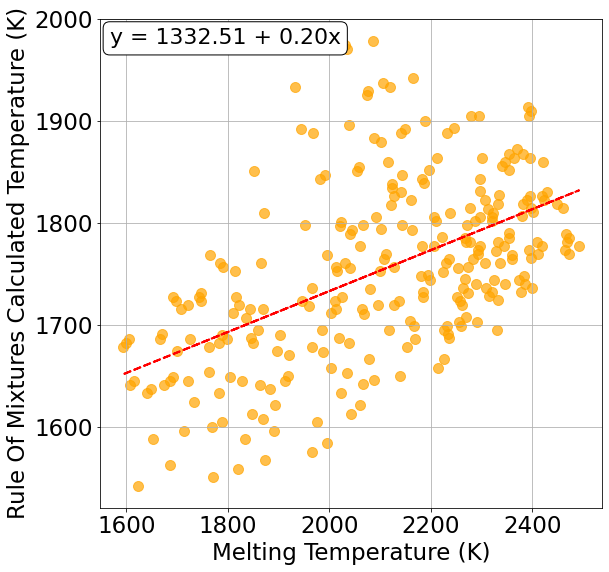

In [17]:
# RULE OF MIXTURES CALCULATED MELTING TEMPERATURE VS MOLECULAR DYNAMICS CALCULATED MELTING TEMPERATURE

plt.figure(figsize=(9, 9))

# Extract data from the DataFrame (relevant columns)
x = known['output.melting_temperature'].values
y = known['melting_point'].values

# Calculate the line of best fit
slope, intercept = np.polyfit(x, y, 1)

# Plot Formatting
plt.scatter(x, y, c='orange', alpha=0.7, s=100)
plt.plot(x, slope*x+intercept, color='red', linestyle='--', linewidth=2)
plt.grid(True)
plt.xlabel('Melting Temperature (K)', fontsize=23)
plt.ylabel('Rule Of Mixtures Calculated Temperature (K)', fontsize=23)
plt.tick_params(axis='both', labelsize=23)

# Calculate the equation of the line of best fit
equation = f'y = {intercept:.2f} + {slope:.2f}x'

#Equation Label
plt.text(0.02, 0.98, equation, transform=plt.gca().transAxes, fontsize=22, ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.show()

In [18]:
print(slope, intercept)

0.2003895711192639 1332.5078439236493


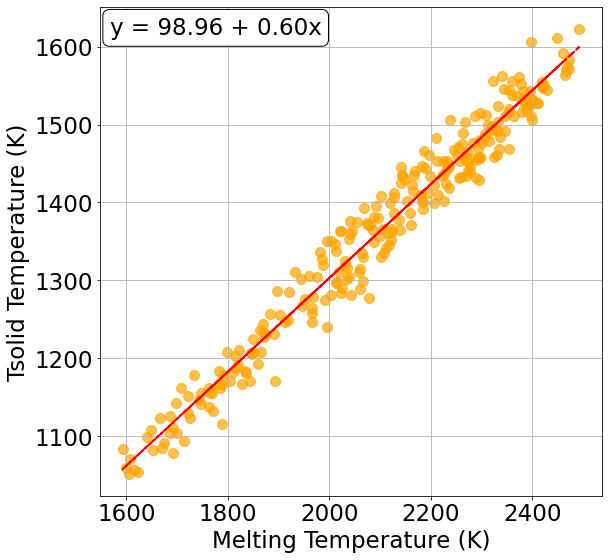

In [19]:
# Tsolid Temperature vs Molecular Dynamics Calculated Melting Temperature

plt.figure(figsize=(9, 9))

# Extract data from the DataFrame (relevant columns)
x = known['output.melting_temperature'].values
y = known['input.Tsolid'].values

# Calculate the line of best fit
slope, intercept = np.polyfit(x, y, 1)

# Plot Formatting
plt.scatter(x, y, c='orange', alpha=0.7, s=100)
plt.plot(x, slope*x+intercept, color='red', linestyle='--', linewidth=2)
plt.grid(True)
common_fontsize = 23
plt.xlabel('Melting Temperature (K)', fontsize=common_fontsize)
plt.ylabel('Tsolid Temperature (K)', fontsize=common_fontsize)
plt.tick_params(axis='both', labelsize=common_fontsize)

# Calculate the equation of the line of best fit
equation = f'y = {intercept:.2f} + {slope:.2f}x'

# Equation Label
plt.text(0.02, 0.98, equation, transform=plt.gca().transAxes, fontsize=common_fontsize, ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.show()


In [20]:
print(slope)
print(intercept)

0.6020591471024813
98.9571768618206


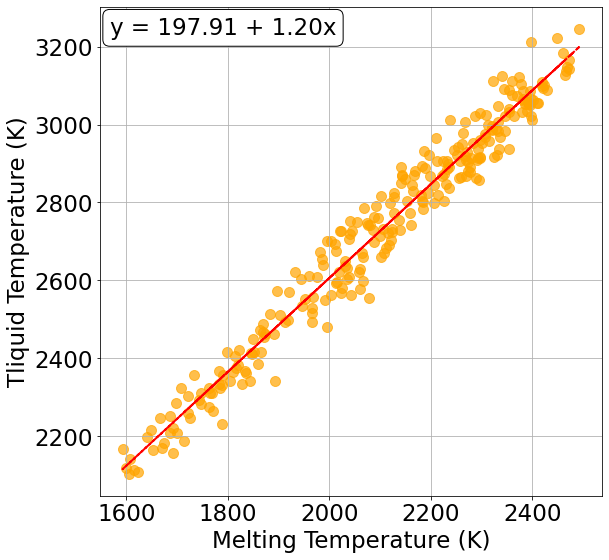

In [21]:
# Tsolid Temperature vs Molecular Dynamics Calculated Melting Temperature

plt.figure(figsize=(9, 9))

# Extract data from the DataFrame
x = known['output.melting_temperature'].values
y = known['input.Tliquid'].values

# Calculate the line of best fit
slope, intercept = np.polyfit(x, y, 1)

#Plot Formatting
plt.scatter(x, y, c='orange', alpha=0.7, s=100)
plt.plot(x, slope*x+intercept, color='red', linestyle='--', linewidth=2)
plt.grid(True)
common_fontsize = 23
plt.xlabel('Melting Temperature (K)', fontsize=common_fontsize)
plt.ylabel('Tliquid Temperature (K)', fontsize=common_fontsize)
plt.tick_params(axis='both', labelsize=common_fontsize)

# Calculate the equation of the line of best fit
equation = f'y = {intercept:.2f} + {slope:.2f}x'

# Equation Label
plt.text(0.02, 0.98, equation, transform=plt.gca().transAxes, fontsize=common_fontsize, ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.show()

In [22]:
print(slope)
print(intercept)

1.2041182942049546
197.9143537236505


 # Random Forest

In [23]:
X = known.iloc[:, :-1]  # Features (all columns except the last one)
y = known.iloc[:, -1]   # Target (Melting Temperature)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Extract data from the DataFrame
x = y_train.values
y = X_train['input.Tsolid'].values

# Calculate the line of best fit (from training data only, to avoid contamination/bias)
slope, intercept = np.polyfit(x, y, 1)

In [27]:
tsol_slope = slope
tsol_intercept = intercept

In [28]:
# Extract data from the DataFrame
x = y_train.values
y = X_train['input.Tliquid'].values

# Calculate the line of best fit
slope, intercept = np.polyfit(x, y, 1)

In [29]:
tliq_slope = slope
tliq_intercept = intercept

In [30]:
X_train.drop(columns = ['input.Tsolid', 'input.Tliquid'], axis = 1, inplace = True)
X_test.drop(columns = ['input.Tsolid', 'input.Tliquid'], axis = 1, inplace = True)

In [31]:
X_test.reset_index(inplace = True)

In [32]:
X_test.drop(columns = ['index'], axis = 1, inplace = True)

In [33]:
X_test.to_csv('rf1_test_inputs.csv', index=False)
X_train.to_csv('rf1_train_inputs.csv', index=False)
y_test.to_csv('rf1_test_outputs.csv', index=False)
y_train.to_csv('rf1_train_outputs.csv', index=False)

In [34]:
#Initialize the Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1778.094791270135


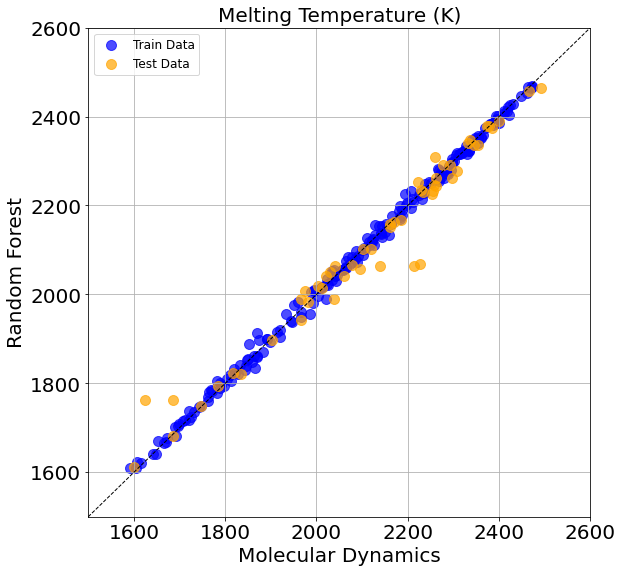

In [36]:
# Calculate predictions for the training data
predictions_train = model.predict(X_train)

# Calculate predictions for the test data
predictions = model.predict(X_test)

#Predicted vs Actual Data for training and testing sets, respectively
a = y_train
a2 = y_test
b = predictions_train
b2 = predictions

#Plot Formatting
plt.figure(figsize=(9, 9))
plt.scatter(a, b, c='blue', label='Train Data', alpha=0.7, s=100)
plt.scatter(a2, b2, c='orange', label='Test Data', alpha=0.7, s=100)
plt.axline((0, 0), slope=1, color='black', linestyle='dashed', linewidth=1)
plt.xlim(1500, 2600)
plt.ylim(1500, 2600)
plt.tick_params(axis='both', labelsize=20) 
plt.xlabel('Molecular Dynamics', fontsize=20)
plt.ylabel('Random Forest', fontsize=20)
plt.title('Melting Temperature (K)', fontsize=20)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [41]:
test_dataset = pd.read_csv('rf1_test_inputs.csv')
data = test_dataset

In [44]:
numpy_array = data.values

# Convert the NumPy array to a PyTorch tensor
data = torch.tensor(numpy_array, dtype=torch.float32)

# Test Set Evaluation

Evaluating the Random Forest on the test set, determining the new average number of simulations per alloy

In [46]:
inputs = getSimToolInputs(MeltHEA)
#print(inputs)

In [47]:
i = 0
for index in data:   
    inputs.time.value = 100 # -> number of picoseconds to run
    inputs.composition1.value = index[0].item()
    inputs.composition2.value = index[1].item()
    inputs.composition3.value = index[2].item()
    inputs.composition4.value = index[3].item()
    inputs.composition5.value = index[4].item()
    #no need to modify
    inputs.box_length.value = 18
    
    
    reshaped_data = index.reshape(1, -1)
    
    prediction = model.predict(reshaped_data).squeeze()
    
    inputs.Tsolid.value = (tsol_slope * prediction) + tsol_intercept
    inputs.Tliquid.value = (tliq_slope * prediction) + tliq_intercept
    r = Run(MeltHEA, inputs) # r is an object -> make list of ex. s.append(r)
    
    dataframe = r.getResultSummary()
    k = dataframe[['name', 'data']]
    k = k.transpose()
    k.columns = k.iloc[0]
    k = k.iloc[1:].reset_index(drop=True)
    k = k.drop('final_snapshot', axis = 1)
    k.to_csv('Alloy Data 5/alloy' + str(i) + '.csv', index=False, float_format='%.6f')
    coexist = bool(r.read('Coexistence'))
    conv = bool(r.read('Converged'))
    comp = 2
    print('First Done')
    
    while ((coexist and conv) is False):

        print('While Loop')
        
        
        inputs.time.value = 100 # -> number of picoseconds to run
        inputs.composition1.value = index[0].item()
        inputs.composition2.value = index[1].item()
        inputs.composition3.value = index[2].item()
        inputs.composition4.value = index[3].item()
        inputs.composition5.value = index[4].item()
        #no need to modify
        inputs.box_length.value = 18

       
        if ((coexist) and (not conv)):
            inputs.time.value = inputs.time.value + 50
        else:
            if (float(r.read('fraction_solid')) >= float(r.read('fraction_liquid'))):
                prediction = prediction * 1.025
            else:
                prediction = prediction * 0.975
    
        inputs.Tsolid.value = (tsol_slope * prediction) + tsol_intercept
        inputs.Tliquid.value = (tliq_slope * prediction) + tliq_intercept
        r = Run(MeltHEA, inputs) # r is an object -> make list of ex. s.append(r)

        dataframe = r.getResultSummary()
        k = dataframe[['name', 'data']]
        k = k.transpose()
        k.columns = k.iloc[0]
        k = k.iloc[1:].reset_index(drop=True)
        k = k.drop('final_snapshot', axis = 1)
        k.to_csv('Alloy Data 5/alloy' + str(i) + '_' + str(comp) + '.csv', index=False, float_format='%.6f')
        comp += 1
        coexist = bool(r.read('Coexistence'))
        conv = bool(r.read('Converged'))

    
    print("done with {}", i)
    i = i + 1

runname = 58812900baa148d69a2d70f6a4e66b7f
outdir  = RUNS/58812900baa148d69a2d70f6a4e66b7f
Checking for cached result
Executing simTool: meltheas/54/baf2784f43eba20a8b21be23ab590d2208e25c1c


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [34:54<00:00, 80.56s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 12:42:25 AM UTC
Finished push to cache: Fri 07 Jun 2024 12:42:37 AM UTC
Fetching cached result
First Done
done with {} 0
runname = 8b22e0f12a544d52b386ed9e7de4c382
outdir  = RUNS/8b22e0f12a544d52b386ed9e7de4c382
Checking for cached result
Executing simTool: meltheas/54/7a0e81e53eb6129857e12f3739582290032376df


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [32:41<00:00, 75.45s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 01:15:45 AM UTC
Finished push to cache: Fri 07 Jun 2024 01:15:58 AM UTC
Fetching cached result
First Done
While Loop
runname = fa2104ad254a4bc4a71672b0d5987313
outdir  = RUNS/fa2104ad254a4bc4a71672b0d5987313
Checking for cached result
Executing simTool: meltheas/54/05f63a6934fabaa38b29e4a2f371889e32a448bd


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [47:17<00:00, 109.14s/cell]


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 02:03:42 AM UTC
Finished push to cache: Fri 07 Jun 2024 02:03:55 AM UTC
Fetching cached result
done with {} 1
runname = cd732155f1fc41e0b7778d564ce4c4c9
outdir  = RUNS/cd732155f1fc41e0b7778d564ce4c4c9
Checking for cached result
Executing simTool: meltheas/54/4ab29a8835a64c507741baa919405de146f35628


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [34:15<00:00, 79.05s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 02:38:37 AM UTC
Finished push to cache: Fri 07 Jun 2024 02:38:49 AM UTC
Fetching cached result
First Done
done with {} 2
runname = 8db428d3a8ee4b31ab8dd0898bb9de16
outdir  = RUNS/8db428d3a8ee4b31ab8dd0898bb9de16
Checking for cached result
Executing simTool: meltheas/54/5a0b187cb4cca08120254608b3b79005ae8f3ac1


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [32:18<00:00, 74.56s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 03:11:34 AM UTC
Finished push to cache: Fri 07 Jun 2024 03:11:46 AM UTC
Fetching cached result
First Done
While Loop
runname = f10a68dbf09e4e20b026ba5c93c824eb
outdir  = RUNS/f10a68dbf09e4e20b026ba5c93c824eb
Checking for cached result
Executing simTool: meltheas/54/748005dd6879e70dfde1c3fc841256c3c1002165


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [31:57<00:00, 73.74s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 03:44:10 AM UTC
Finished push to cache: Fri 07 Jun 2024 03:44:22 AM UTC
Fetching cached result
done with {} 3
runname = 87b74fbd6bf34337b2c1b19bcf30fd36
outdir  = RUNS/87b74fbd6bf34337b2c1b19bcf30fd36
Checking for cached result
Executing simTool: meltheas/54/46abb9e3ae6dcdcfcfd14b9454ef5d85d81b23b3


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [32:14<00:00, 74.41s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 04:17:04 AM UTC
Finished push to cache: Fri 07 Jun 2024 04:17:16 AM UTC
Fetching cached result
First Done
done with {} 4
runname = c9d13a2c52cc4bce90a6a9c83b0004a5
outdir  = RUNS/c9d13a2c52cc4bce90a6a9c83b0004a5
Checking for cached result
Executing simTool: meltheas/54/4533253df2878389c0e94096c1ff85374bcd7ece


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [32:41<00:00, 75.43s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 04:50:24 AM UTC
Finished push to cache: Fri 07 Jun 2024 04:50:36 AM UTC
Fetching cached result
First Done
While Loop
runname = 1532e8fa27a948de9810ab92156c114e
outdir  = RUNS/1532e8fa27a948de9810ab92156c114e
Checking for cached result
Executing simTool: meltheas/54/4f6b6d2f19b21264a35276e9f77af5b84c98df48


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [32:58<00:00, 76.10s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 05:24:01 AM UTC
Finished push to cache: Fri 07 Jun 2024 05:24:14 AM UTC
Fetching cached result
done with {} 5
runname = d90bc82dfa174da8bf3b8236f56b81ae
outdir  = RUNS/d90bc82dfa174da8bf3b8236f56b81ae
Checking for cached result
Executing simTool: meltheas/54/418d784e5ab9b9277b8093e8221786a7a1bb0d3e


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [33:48<00:00, 78.01s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 05:58:29 AM UTC
Finished push to cache: Fri 07 Jun 2024 05:58:41 AM UTC
Fetching cached result
First Done
done with {} 6
runname = e45657d2aea748d498834b029cae9db5
outdir  = RUNS/e45657d2aea748d498834b029cae9db5
Checking for cached result
Executing simTool: meltheas/54/e9727c936fc3a48d5f9c85c73168e37a8ca7eeda


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [32:59<00:00, 76.14s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 06:32:07 AM UTC
Finished push to cache: Fri 07 Jun 2024 06:32:19 AM UTC
Fetching cached result
First Done
While Loop
runname = 6256343e6c4a4e4ca4dc9721f7114861
outdir  = RUNS/6256343e6c4a4e4ca4dc9721f7114861
Checking for cached result
Executing simTool: meltheas/54/f459b06f508a854de1b20f07ef4c449fd01b22e0


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [47:42<00:00, 110.09s/cell]


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 07:20:28 AM UTC
Finished push to cache: Fri 07 Jun 2024 07:20:48 AM UTC
Fetching cached result
done with {} 7
runname = 07e1597702e74a2e94919e62fc9caee4
outdir  = RUNS/07e1597702e74a2e94919e62fc9caee4
Checking for cached result
Executing simTool: meltheas/54/a435ee0057c061f730aae230b4ef04a3db808a5a


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [31:24<00:00, 72.49s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 07:52:41 AM UTC
Finished push to cache: Fri 07 Jun 2024 07:52:53 AM UTC
Fetching cached result
First Done
done with {} 8
runname = 991be538d749481d9643988b941eefc3
outdir  = RUNS/991be538d749481d9643988b941eefc3
Checking for cached result
Executing simTool: meltheas/54/221cc6585896c8a00a5116d74e32c3ce23740fcf


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [33:25<00:00, 77.13s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 08:26:48 AM UTC
Finished push to cache: Fri 07 Jun 2024 08:27:01 AM UTC
Fetching cached result
First Done
done with {} 9
runname = e4fba05d0b634cb292397c2a32a77878
outdir  = RUNS/e4fba05d0b634cb292397c2a32a77878
Checking for cached result
Executing simTool: meltheas/54/a3322630485b730ce43cba6943c309a813f05bc6


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [31:03<00:00, 71.66s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 08:58:39 AM UTC
Finished push to cache: Fri 07 Jun 2024 08:58:51 AM UTC
Fetching cached result
First Done
While Loop
runname = d76fb6af42c84fe3ad076b025bd15e72
outdir  = RUNS/d76fb6af42c84fe3ad076b025bd15e72
Checking for cached result
Executing simTool: meltheas/54/7dde43516e7fd337652679fdfa0b57da44f8a028


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [31:10<00:00, 71.95s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 09:30:29 AM UTC
Finished push to cache: Fri 07 Jun 2024 09:30:42 AM UTC
Fetching cached result
While Loop
runname = 6afe12caab25420d9fbe90e4d04738b7
outdir  = RUNS/6afe12caab25420d9fbe90e4d04738b7
Checking for cached result
Executing simTool: meltheas/54/1e295ddf723962b5dea42b4a31aab905947c2244


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [31:16<00:00, 72.18s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 10:02:26 AM UTC
Finished push to cache: Fri 07 Jun 2024 10:02:39 AM UTC
Fetching cached result
While Loop
runname = 6d1e554c04684e2baa7831061126051a
outdir  = RUNS/6d1e554c04684e2baa7831061126051a
Checking for cached result
Executing simTool: meltheas/54/7ab039174d57a8eeaa2aa9fef3ee5ac48c645412


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [31:30<00:00, 72.70s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 10:34:37 AM UTC
Finished push to cache: Fri 07 Jun 2024 10:34:49 AM UTC
Fetching cached result
done with {} 10
runname = 8fa03144a90e49e0b26e5035418238dd
outdir  = RUNS/8fa03144a90e49e0b26e5035418238dd
Checking for cached result
Executing simTool: meltheas/54/cb005a0deb1c3382ccec6a6d6d6a3245c5a33f54


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [33:09<00:00, 76.52s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 11:08:26 AM UTC
Finished push to cache: Fri 07 Jun 2024 11:08:38 AM UTC
Fetching cached result
First Done
done with {} 11
runname = 3ec083697ad14d11a3ff5f40cdcb4610
outdir  = RUNS/3ec083697ad14d11a3ff5f40cdcb4610
Checking for cached result
Executing simTool: meltheas/54/8e33f7c207426d4e5df8b1aec8dc2fe0bfce5b4a


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [32:19<00:00, 74.58s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 11:41:24 AM UTC
Finished push to cache: Fri 07 Jun 2024 11:41:36 AM UTC
Fetching cached result
First Done
done with {} 12
runname = f518c199962940b5ae8e57c94494aa5b
outdir  = RUNS/f518c199962940b5ae8e57c94494aa5b
Checking for cached result
Executing simTool: meltheas/54/46431eb67bea484f13b2a7e88aa7316aef75520e


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [33:15<00:00, 76.74s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 12:15:21 PM UTC
Finished push to cache: Fri 07 Jun 2024 12:15:34 PM UTC
Fetching cached result
First Done
done with {} 13
runname = 698bd8ea7dc64d5cbf2eaf40ff5fbe3f
outdir  = RUNS/698bd8ea7dc64d5cbf2eaf40ff5fbe3f
Checking for cached result
Executing simTool: meltheas/54/0fc1615b55c795a7f081a5efcdc46a7f026ba92b


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [33:24<00:00, 77.10s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 12:49:25 PM UTC
Finished push to cache: Fri 07 Jun 2024 12:49:37 PM UTC
Fetching cached result
First Done
done with {} 14
runname = 44ca95cfb5c6427f9ce1c1c1cc199550
outdir  = RUNS/44ca95cfb5c6427f9ce1c1c1cc199550
Checking for cached result
Executing simTool: meltheas/54/564eeeaaf13006838b02ca5792443979890c9be0


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [31:28<00:00, 72.64s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 01:21:32 PM UTC
Finished push to cache: Fri 07 Jun 2024 01:21:44 PM UTC
Fetching cached result
First Done
done with {} 15
runname = 76cd137b294a4e198996c3d250513c1a
outdir  = RUNS/76cd137b294a4e198996c3d250513c1a
Checking for cached result
Executing simTool: meltheas/54/848bc19de5b37217cd6f194bd93959d2139e343e


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [32:34<00:00, 75.18s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 01:54:45 PM UTC
Finished push to cache: Fri 07 Jun 2024 01:54:57 PM UTC
Fetching cached result
First Done
done with {} 16
runname = 3f52eb814186455fbe48e3ba0083b18e
outdir  = RUNS/3f52eb814186455fbe48e3ba0083b18e
Checking for cached result
Executing simTool: meltheas/54/0a727c22ccc632f482dd21d6d24827988a3f2d6c


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [33:56<00:00, 78.33s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 02:29:20 PM UTC
Finished push to cache: Fri 07 Jun 2024 02:29:32 PM UTC
Fetching cached result
First Done
done with {} 17
runname = 636d1beb9fa5463daf3de03084cd9e2b
outdir  = RUNS/636d1beb9fa5463daf3de03084cd9e2b
Checking for cached result
Executing simTool: meltheas/54/19db1223d6d949b9050983e311b223c404a7da0c


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [32:52<00:00, 75.86s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 03:02:51 PM UTC
Finished push to cache: Fri 07 Jun 2024 03:03:02 PM UTC
Fetching cached result
First Done
done with {} 18
runname = 64da1bf6cdcf49da8c84a8cba9496aa4
outdir  = RUNS/64da1bf6cdcf49da8c84a8cba9496aa4
Checking for cached result
Executing simTool: meltheas/54/ecb6b8a2d385a51d0e02c0cff4ea565b9d80e1dd


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [33:28<00:00, 77.25s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 03:36:57 PM UTC
Finished push to cache: Fri 07 Jun 2024 03:37:09 PM UTC
Fetching cached result
First Done
done with {} 19
runname = 1e511d093c3043879c3a3c2708761884
outdir  = RUNS/1e511d093c3043879c3a3c2708761884
Checking for cached result
Executing simTool: meltheas/54/b318b6372ac2f427ea00cf71dd7fcf63d6b958f9


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [33:31<00:00, 77.37s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 04:11:07 PM UTC
Finished push to cache: Fri 07 Jun 2024 04:11:19 PM UTC
Fetching cached result
First Done
done with {} 20
runname = b303f048a1a14671889fe58e8bf055d3
outdir  = RUNS/b303f048a1a14671889fe58e8bf055d3
Checking for cached result
Executing simTool: meltheas/54/1ed6fcc5502e3f9be4610a3b2d1a7af3f37e4039


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [32:47<00:00, 75.68s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 04:44:33 PM UTC
Finished push to cache: Fri 07 Jun 2024 04:44:45 PM UTC
Fetching cached result
First Done
While Loop
runname = 96187778110845f09840a2f6a5402ae9
outdir  = RUNS/96187778110845f09840a2f6a5402ae9
Checking for cached result
Executing simTool: meltheas/54/97c50d96af2af51efd8f97053458f5972061c2fd


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [47:52<00:00, 110.48s/cell]


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 05:33:04 PM UTC
Finished push to cache: Fri 07 Jun 2024 05:33:17 PM UTC
Fetching cached result
done with {} 21
runname = 75176a08efd64946a362b407fdd11c34
outdir  = RUNS/75176a08efd64946a362b407fdd11c34
Checking for cached result
Executing simTool: meltheas/54/9303caeae780cb22518170ab190cf8b78b2d0f2b


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [33:54<00:00, 78.26s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 06:07:38 PM UTC
Finished push to cache: Fri 07 Jun 2024 06:07:50 PM UTC
Fetching cached result
First Done
done with {} 22
runname = e01f7ad7a5a6468e873a473b7b73d0bc
outdir  = RUNS/e01f7ad7a5a6468e873a473b7b73d0bc
Checking for cached result
Executing simTool: meltheas/54/f68fa0f30759247bff40bb14e2680605d85e43d7


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [34:04<00:00, 78.64s/cell] 


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 06:42:21 PM UTC
Finished push to cache: Fri 07 Jun 2024 06:42:33 PM UTC
Fetching cached result
First Done
While Loop
runname = 05fcf9a9705546d1837eb5d44dde8168
outdir  = RUNS/05fcf9a9705546d1837eb5d44dde8168
Checking for cached result
Executing simTool: meltheas/54/bc16866b4f03666828461f8d15bbf827fb6cb11c


Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing: 100%|██████████| 26/26 [49:08<00:00, 113.41s/cell]


Archiving SimTool Result
Starting push to cache: Fri 07 Jun 2024 07:32:09 PM UTC
Finished push to cache: Fri 07 Jun 2024 07:32:21 PM UTC
Fetching cached result
done with {} 23
runname = 79f3c32a655f40b6bc9b720a2e4894d6
outdir  = RUNS/79f3c32a655f40b6bc9b720a2e4894d6
Checking for cached result
Found cached result = meltheas/54/bfe9489d085f889800ba5752ac96205dcd0d9204
First Done
done with {} 24
runname = 06e284b79f8e42339e8b52df7a76e34b
outdir  = RUNS/06e284b79f8e42339e8b52df7a76e34b
Checking for cached result
Found cached result = meltheas/54/f7f12077f5ff8ba6081520ba1bbaa6306b35eb9b
First Done
done with {} 25
runname = 9ddfdcc525cd4b3ea0e6c56d9dd5b3bf
outdir  = RUNS/9ddfdcc525cd4b3ea0e6c56d9dd5b3bf
Checking for cached result
Found cached result = meltheas/54/e73445d67a44664914bd83117aad31f290053961
First Done
done with {} 26
runname = fc9a3d0f862a4c17a0bb7e807e15a428
outdir  = RUNS/fc9a3d0f862a4c17a0bb7e807e15a428
Checking for cached result
Found cached result = meltheas/54/8d91afc6a586

Input Notebook:  /apps/meltheas/r54/simtool/meltheas.ipynb
Output Notebook: meltheas.ipynb
Executing notebook with kernel: python3
Executing:  50%|█████     | 13/26 [00:19<00:04,  3.11cell/s]

Fetching error result
Retrieval of failed execution result failed


Traceback (most recent call last):
  File "/apps/share64/debian10/anaconda/anaconda-7/lib/python3.8/site-packages/simtool/run.py", line 313, in doTrustedUserRun
    exitCode,commandStdout,commandStderr = self.executeCommand(commandArgs,streamOutput=True,reportErrorExit=False)
  File "/apps/share64/debian10/anaconda/anaconda-7/lib/python3.8/site-packages/simtool/run.py", line 223, in executeCommand
    ready = select.select(toCheck,[],[])
KeyboardInterrupt

/bin/cp: cannot stat '/tmp/SimToolDeliver/fe1085e0-7d55-4497-9552-080ea279fb07/.': No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: 'RUNS/a0c8b60ee922464db85fb6e419ce9a1a/meltheas.ipynb'

# Random Forest Evalution

Evaluating the Random Forest's reduction in average simulations

In [67]:
#Reading a list of values processed before simulations ran
df = pd.read_csv('cleaned_list.txt', sep=' ', header=None)
df[8] = [x.replace("_", "/") for x in df[8]]
runs_file = final_df.copy()

#Keep only data that's present in df (matches by sqUID)
prior_to_2024_data = runs_file[runs_file['squid'].isin(df[8])]
df = prior_to_2024_data.copy()

In [69]:
#Processing number of simulations per composition for data: new sims ran
cols = ['Cr', 'Co', 'Cu', 'Fe', 'Ni']

filtered_df = pd.DataFrame()

k = 0

for index in range(54): 
    counter = 1
    v = 2
    file_path = 'Alloy Data 5/alloy' + str(index) + '.csv'
    k = pd.read_csv(file_path)
    k.rename(columns = {'true_comp1': 'Cr', 'true_comp2': 'Co', 'true_comp3': 'Cu', 'true_comp4': 'Fe', 'true_comp5': 'Ni'}, inplace = True)
    
    cr = round(k['Cr'].item(), 1)
    co = round(k['Co'].item(), 1)
    cu = round(k['Cu'].item(), 1)
    fe = round(k['Fe'].item(), 1)
    ni = round(k['Ni'].item(), 1)
    
    temp_df = df[(df['Cr'] == cr) & (df['Co'] == co) & (df['Cu'] == cu) & (df['Fe'] == fe) & (df['Ni'] == ni)]
    
    
    filtered_df = pd.concat([filtered_df, temp_df], ignore_index=True)

In [70]:
df = filtered_df

In [71]:
#Grouping elemenets by composition
cols = ['Cr', 'Co', 'Cu', 'Fe', 'Ni']
groups = df.groupby(by = cols)
list_of_averages = []
unconverged_alloys = []

In [72]:
#Constructing list of avg number of sims till convergence for each group/composition
for i, g in groups:
    if (len(g[(g['output.Coexistence'] == 1) & (g['output.Converged'] == 1)]) != 0):
        average = len(g)/len(g[(g['output.Coexistence'] == 1) & (g['output.Converged'] == 1)])
        list_of_averages.append(average)
    else:
        unconverged_alloys.append(i)

In [73]:
#Processing number of simulations per composition for data: new sims ran
list_av = []
for index in range(54): 
    counter = 1
    v = 2
    file_path = 'Alloy Data 5/alloy' + str(index) + '_' + str(v) + '.csv'
    while (os.path.exists(file_path)):
        counter += 1
        v += 1
        file_path = 'Alloy Data 5/alloy' + str(index) + '_' + str(v) + '.csv'
    list_av.append(counter)

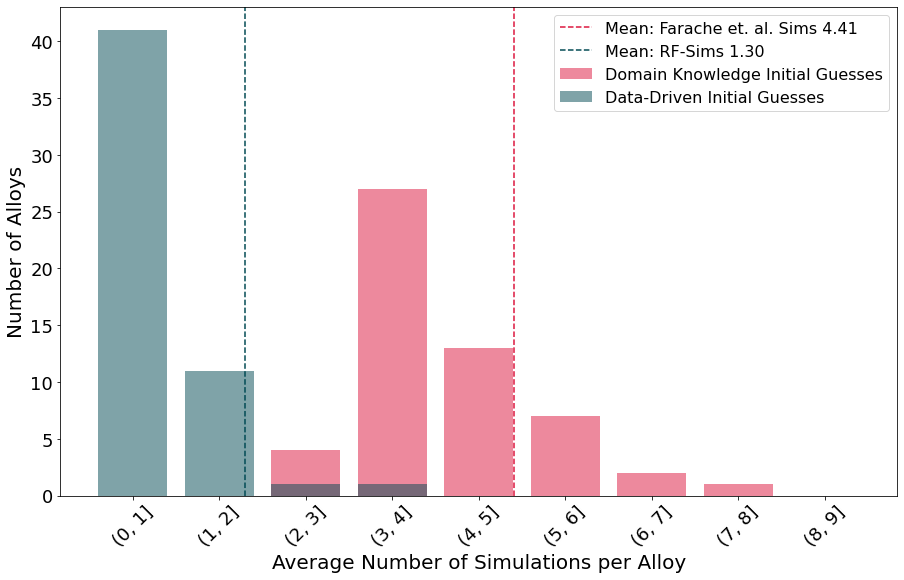

In [74]:
values_list1 = list_of_averages  # Make sure this variable is correctly defined
values_list2 = list_av  # Ensure this variable is correctly defined

bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

binned_values1 = pd.cut(values_list1, bins=bins)
bin_counts1 = binned_values1.value_counts().sort_index()

binned_values2 = pd.cut(values_list2, bins=bins)
bin_counts2 = binned_values2.value_counts().sort_index()

total_counts1 = bin_counts1.sum()
total_counts2 = bin_counts2.sum()

# Change to count-based values
counts1 = bin_counts1.values
counts2 = bin_counts2.values

bin_labels = bin_counts1.index.astype(str)

plt.figure(figsize=(15, 9))
plt.bar(bin_labels, counts1, alpha=0.5, label='Domain Knowledge Initial Guesses', color = '#DC143C')
plt.bar(bin_labels, counts2, alpha=0.5, label='Data-Driven Initial Guesses', color='#004953')

plt.tick_params(axis='both', labelsize=18)

# Reintroduce the mean lines
mean_value1 = sum(values_list1) / len(values_list1)
mean_value2 = sum(values_list2) / len(values_list2)

# Draw vertical lines at the mean values
plt.axvline(x=mean_value1, color='#DC143C', linestyle='--', label='Mean: Farache et. al. Sims {:.2f}'.format(mean_value1))
plt.axvline(x=mean_value2, color='#004953', linestyle='--', label='Mean: RF-Sims {:.2f}'.format(mean_value2))

plt.xlabel('Average Number of Simulations per Alloy', fontsize = 20)
plt.ylabel('Number of Alloys', fontsize = 20)
plt.xticks(rotation=45)
plt.legend(fontsize = 16)

plt.show()